In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import os
from pathlib import Path

import pytorch_lightning as pl
import torch
import wandb
from sdofm import utils
from sdofm.datasets import SDOMLDataModule, DimmedSDOMLDataModule
from sdofm.pretraining import SAMAE

In [11]:
import omegaconf

# cfg = omegaconf.OmegaConf.load("../experiments/pretrain_32.2M_samae.yaml")
cfg = omegaconf.OmegaConf.load("../experiments/default.yaml")

In [46]:
data_module = SDOMLDataModule(
    hmi_path=None,
    aia_path=os.path.join(
        cfg.data.sdoml.base_directory, cfg.data.sdoml.sub_directory.aia
    ),
    eve_path=None,
    components=cfg.data.sdoml.components,
    wavelengths=cfg.data.sdoml.wavelengths,
    ions=cfg.data.sdoml.ions,
    frequency=cfg.data.sdoml.frequency,
    batch_size=cfg.model.opt.batch_size,
    num_workers=cfg.data.num_workers,
    val_months=cfg.data.month_splits.val,
    test_months=cfg.data.month_splits.test,
    holdout_months=cfg.data.month_splits.holdout,
    cache_dir=os.path.join(
        cfg.data.sdoml.base_directory, cfg.data.sdoml.sub_directory.cache
    ),
    min_date=cfg.data.min_date,
    max_date=cfg.data.max_date,
)
data_module.setup()

[* CACHE SYSTEM *] Found cached index data in /mnt/sdoml/cache/aligndata_AIA_FULL_12min.csv.
[* CACHE SYSTEM *] Found cached normalization data in /mnt/sdoml/cache/normalizations_AIA_FULL_12min.json.
[* CACHE SYSTEM *] Found cached HMI mask data in /mnt/sdoml/cache/hmi_mask_512x512.npy.


In [47]:
ts = data_module.train_ds.aligndata
ts.shape

(20267, 9)

(134044, 9)

In [5]:
# model = SAMAE(
#     **cfg.model.mae,
#     **cfg.model.samae,
#     optimiser=cfg.model.opt.optimiser,
#     lr=cfg.model.opt.learning_rate,
#     weight_decay=cfg.model.opt.weight_decay,
# )

In [7]:
model = SAMAE.load_from_checkpoint(
    **cfg.model.mae,
    **cfg.model.samae,
    optimiser=cfg.model.opt.optimiser,
    lr=cfg.model.opt.learning_rate,
    weight_decay=cfg.model.opt.weight_decay,
    checkpoint_path="/home/walsh/repos/SDO-FM/output/2024-04-17-00-41-29/0/sdofm/zy68fa00/checkpoints/epoch=3-step=48556.ckpt"
)

In [ ]:
trainer = pl.Trainer(
    devices=1, accelerator=cfg.experiment.accelerator, max_epochs=cfg.model.opt.epochs
)
trainer.fit(model=model, datamodule=data_module)

In [8]:
sample = next(iter(data_module.test_dataloader())).to(model.device)

In [9]:
sample.shape

torch.Size([3, 9, 1, 512, 512])

In [10]:
loss, x_hat, mask = model.predict_step(sample)

In [11]:
x_hat.shape

torch.Size([3, 9, 1, 512, 512])

In [12]:
sample.shape

torch.Size([3, 9, 1, 512, 512])

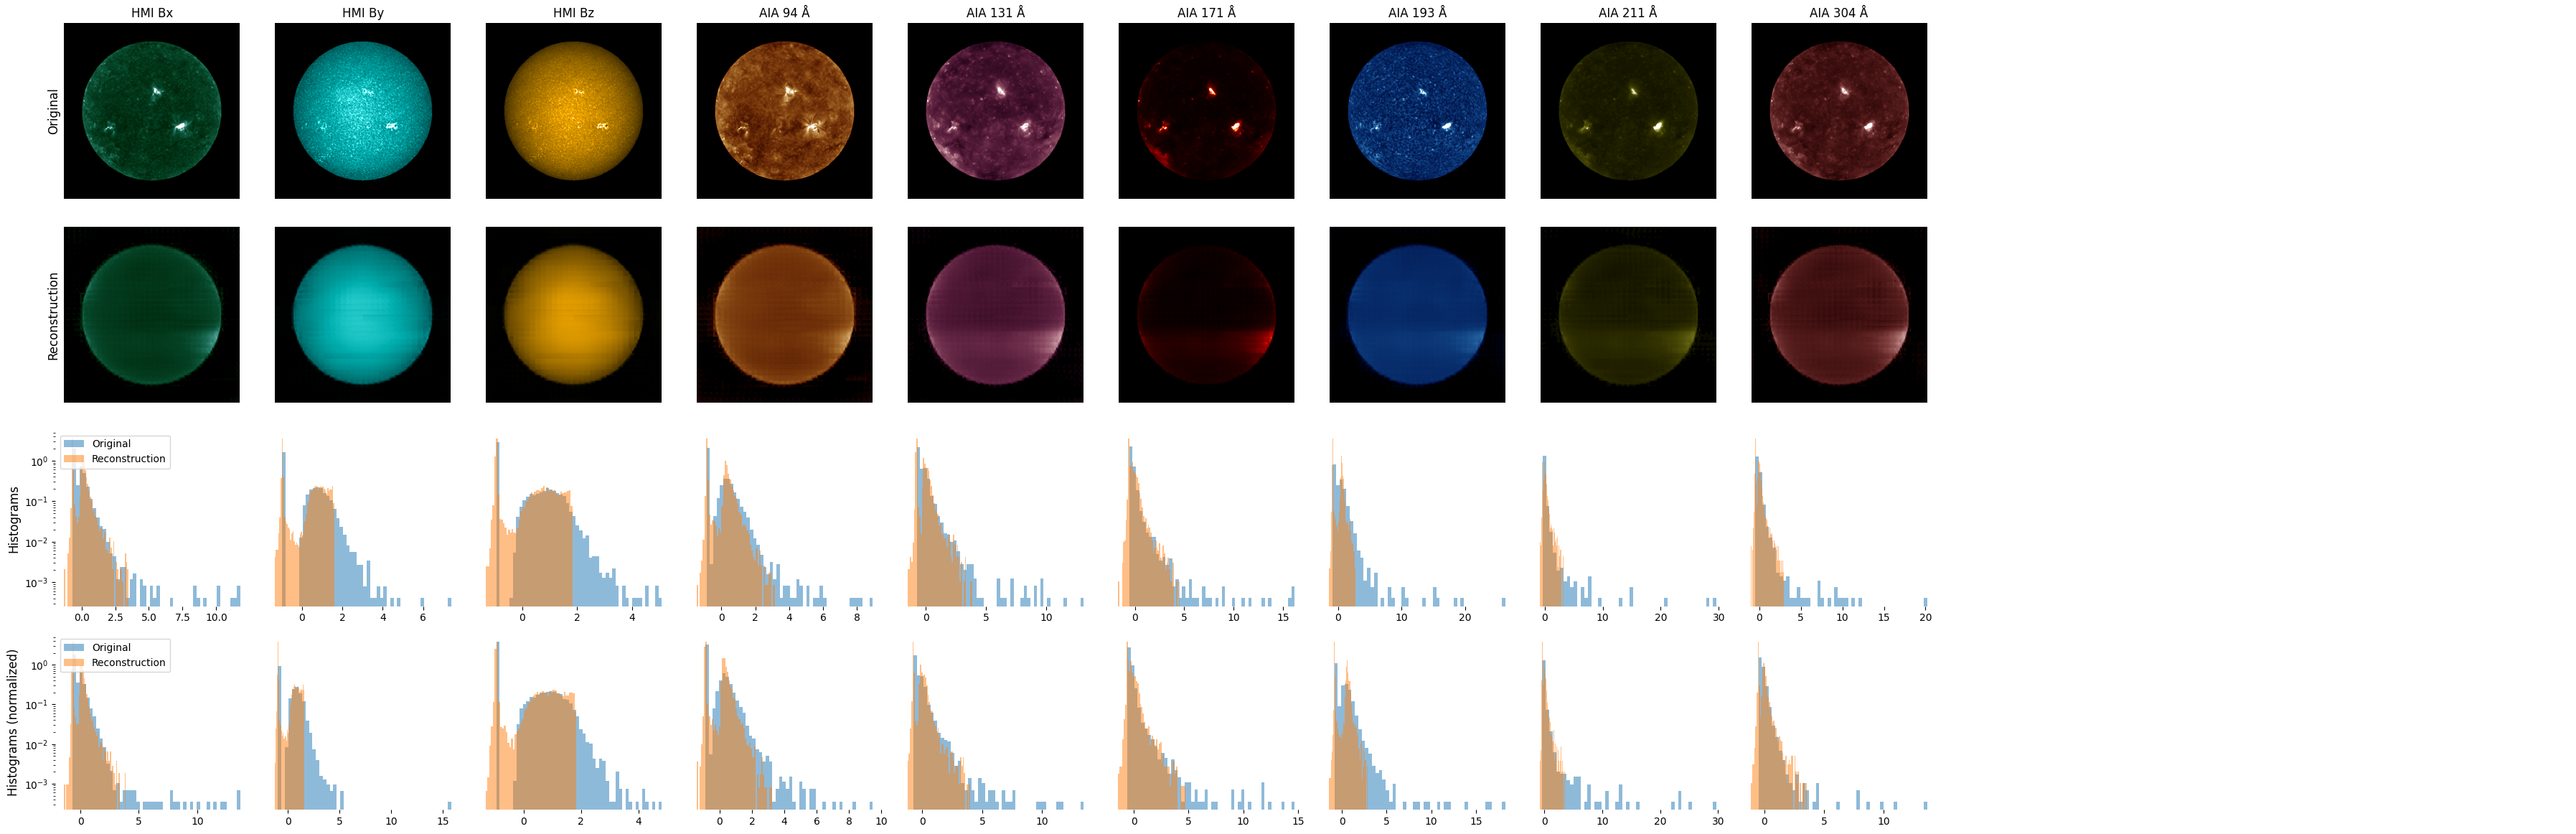

In [13]:
from sdofm.visualisation.sdo import sdo_reconstruction_plot
from matplotlib import pyplot as plt

sdo_reconstruction_plot(
    sample[0, :, 0, :, :], x_hat[0, :, 0, :, :], data_normalized=True
)
plt.show()